# Decision Trees

## Import Libraries

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

## Import

I'll bring back my wrangle function from the data exploration phase 

In [2]:
def wrangle(filepath):
    # read csv into DataFrame
    df = pd.read_csv(filepath)
    
    # Rename columns for better clarity and to facilitate analysis
    df.rename(columns={'Age in 5-year groups': 'age',
                       'Type of place of residence': 'residence',
                       'Highest educational level': 'educational_level',
                       'Wealth index combined': 'wealth_index',
                       'Births in last five years': 'births_5_years',
                       'Age of respondent at 1st birth': 'respondent_1st_birth',
                       'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)': 'hemoglobin_altitude_smoking',
                       'Anemia level': 'anemia_level_target',
                       'Have mosquito bed net for sleeping (from household questionnaire)': 'mosquito_net_owners',
                       'Smokes cigarettes': 'smokers',
                       'Current marital status': 'marital_status',
                       'Currently residing with husband/partner': 'partner_residence',
                       'When child put to breast': 'child_put_breast',
                       'Had fever in last two weeks': 'fever_two_weeks',
                       'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)': 'hemoglobin_altitude',
                       'Anemia level.1': 'anemia_level_1',
                       'Taking iron pills, sprinkles or syrup': 'iron_pills'}, inplace=True)
    
    # drop collumn with 50% null values .
    df.drop(columns="anemia_level_1" , inplace = True)
    
    # List of columns to impute
    columns_to_impute = ['hemoglobin_altitude_smoking','hemoglobin_altitude']

    # Convert relevant columns to numeric before imputing
    numeric_columns = columns_to_impute
    for column in numeric_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Impute missing values with mean
    for column in columns_to_impute:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
        
    # drop the column for high cardinality
    df.drop(columns="child_put_breast", inplace=True)  
    
    # Fill NaN values in specified columns with the string "Dont know"
    df['anemia_level_target'] = df['anemia_level_target'].fillna("Dont know") 
    
    #'Anemia level'  mapping
    category_mapping = {'Dont know': 0, 'Moderate': 1, 'Mild': 2, 'Not anemic': 3, 'Severe': 4}

    # Map the categories to numerical values
    df['anemia_level_target'] = df['anemia_level_target'].map(category_mapping)
    
    
    # define a function
    def replace_nan_with_word(x, word='Staying elsewhere'):
        """
        Replace NaN values in a pandas Series with a specified word.

        Parameters:
        - x: pandas Series
        - word: str, default='Staying elsewhere'
        """
        return x.fillna(word)

    # Apply the function to replace NaN values in the column
    df['partner_residence'] = replace_nan_with_word(df['partner_residence'])

    # Fill NaN values in the 'fever_two_weeks' column with the string "Dont know"
    df['fever_two_weeks'] = df['fever_two_weeks'].fillna("Dont know")
    
    # Fill NaN values in the 'iron_pills' column with the string "Dont know"
    df['iron_pills'] = df['iron_pills'].fillna("Dont know")
    

    return df

In [3]:
df = wrangle("children anemia.csv")
df.head()

,age,residence,educational_level,wealth_index,births_5_years,respondent_1st_birth,hemoglobin_altitude_smoking,anemia_level_target,mosquito_net_owners,smokers,marital_status,partner_residence,fever_two_weeks,hemoglobin_altitude,iron_pills
0,40-44,Urban,Higher,Richest,1,22,114.367235,0,Yes,No,Living with partner,Staying elsewhere,No,101.270183,Yes
1,35-39,Urban,Higher,Richest,1,28,114.367235,0,Yes,No,Married,Living with her,No,101.270183,No
2,25-29,Urban,Higher,Richest,1,26,114.367235,0,No,No,Married,Living with her,No,101.270183,No
3,25-29,Urban,Secondary,Richest,1,25,95.000000,1,Yes,No,Married,Living with her,No,114.000000,No
4,20-24,Urban,Secondary,Richest,1,21,114.367235,0,Yes,No,No longer living together/separated,Staying elsewhere,No,101.270183,No


## Split

I'll Create my feature matrix X and target vector y. My target is "anemia_level_target"

In [4]:
# create feature and target .
target = "anemia_level_target"
X = df.drop(columns=target)
y = df[target]

I'll now use a randomized train-test split to divide my data (X and Y) into training and test sets. 20% of my entire data are in my test set. Next, to ensure reproducibility, I'll set a random state.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27139, 14)
y_train shape: (27139,)
X_test shape: (6785, 14)
y_test shape: (6785,)


## Build Model

### Baseline

Calculate the baseline accuracy score for my model.

In [6]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.61


In [7]:
# Build Model
model = make_pipeline(
   OrdinalEncoder(), DecisionTreeClassifier(max_depth=6, random_state=42)
)
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['age', 'residence', 'educational_level',
                                      'wealth_index', 'mosquito_net_owners',
                                      'smokers', 'marital_status',
                                      'partner_residence', 'fever_two_weeks',
                                      'iron_pills'],
                                mapping=[{'col': 'age', 'data_type': dtype('O'),
                                          'mapping': 20-24    1
30-34    2
15-19    3
25-29    4
35-39    5
40-44    6
45-49    7
NaN     -2
dtype: int64},
                                         {'col': 'residence',
                                          'data_t...
                                          'data_type': dtype('O'),
                                          'mapping': Living with her      1
Staying elsewhere    2
NaN                 -2
dtype: int64},
                                         {'col': 'fever

Next i'll Calculate the training accuracy score for my model.

In [8]:
#t Accuracy score for training Data
acc_train = accuracy_score(y_train,model.predict(X_train)) 
print("Training Accuracy:", round(acc_train, 2))

Training Accuracy: 0.97


## Evaluate

In [9]:
test_acc = model.score(X_test,y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.97


Next i'll assign the feature names and importances of my model to the variables below. For the features, they are the column names in my training set. For the importances, they are the feature_importances_ attribute of my model's DecisionTreeClassifier.

In [10]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_


print("Features:", features[:4])
print("Importances:", importances[:4])

Features: Index(['age', 'residence', 'educational_level', 'wealth_index'], dtype='object')
Importances: [0.00034806 0.         0.0001557  0.00013178]


Next i'll Create a pandas Series named feat_imp, where the index is features and the values are my importances. The Series will be sorted from smallest to largest importance.

In [11]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

residence              0.0
mosquito_net_owners    0.0
partner_residence      0.0
fever_two_weeks        0.0
iron_pills             0.0
dtype: float64

Next i'll visualze by Creating a horizontal bar chart with all the features in feat_imp

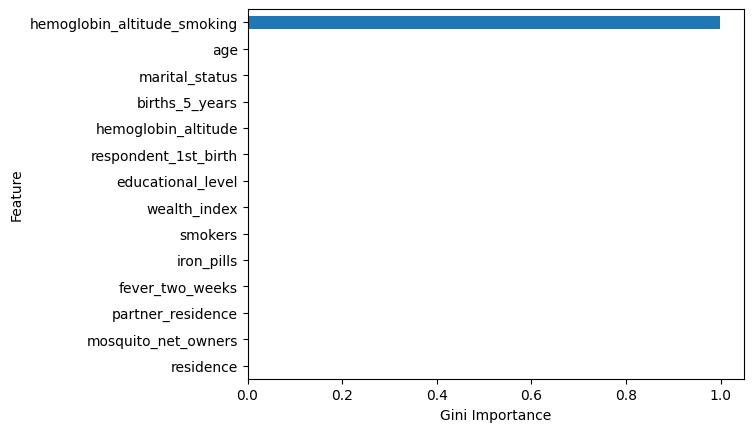

In [12]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

a Gini importance of 1 for hemoglobin_altitude_smoking feature indicates that this feature is highly valuable for creating splits that lead to pure nodes in the decision tree. It is a strong predictor and plays a crucial role in the model's decision-making process.